In [2]:
import csv
import pandas as pd
pd.set_option('max_colwidth', 200)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [3]:
pd.set_option('max_colwidth', 4000)

In [4]:
domains = pd.read_csv('domains.csv')
requests= pd.read_csv('requests.csv')
urls_no_action_taken= pd.read_csv('urls-no-action-taken.csv')

# Requests

In [6]:
requests.dtypes

Request ID                                      int64
Date                                           object
Lumen URL                                      object
Copyright owner ID                              int64
Copyright owner name                           object
Reporting organization ID                       int64
Reporting organization name                    object
URLs removed                                    int64
URLs that were not in Google's search index     int64
URLs for which we took no action                int64
URLs pending review                             int64
From Abuser                                      bool
dtype: object

In [7]:
requests['Date']= pd.to_datetime(requests['Date'])
requests['Date']= requests['Date'].dt.date
requests['Date']= pd.to_datetime(requests['Date'])
requests['Year'] = requests['Date'].dt.year

# Clean columns ['Copright owner namee'] and ['Reporting organiation name']
requests['Copyright owner name_cleaned'] = requests['Copyright owner name'].str.lower().replace("[^a-zA-Z0-9]", '', regex=True)
requests['Reporting organization name_cleaned'] = requests['Reporting organization name'].str.lower().replace("[^a-zA-Z0-9]", '', regex=True)

#Create column to match Reporting organiation name and Copright owner name
a = requests[['Copyright owner name', 'Reporting organization name']].apply(lambda x: x.str.replace(r'[^\w]', '').str.lower())
requests['Owner_ReportingOrg_match'] = a['Copyright owner name'] == a['Reporting organization name']

Text(0,0.5,'Number of Removal Requests')

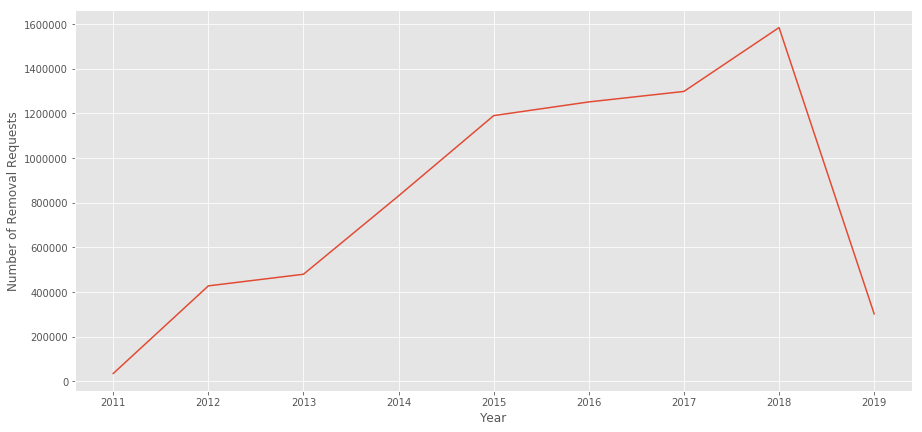

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
requests.groupby(['Year']).count()['Request ID'].plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Removal Requests')

In [9]:
requests[requests['From Abuser']==True]['Request ID'].count()

52492

Text(0.5,1,'Number of Removal Requests from Abusers')

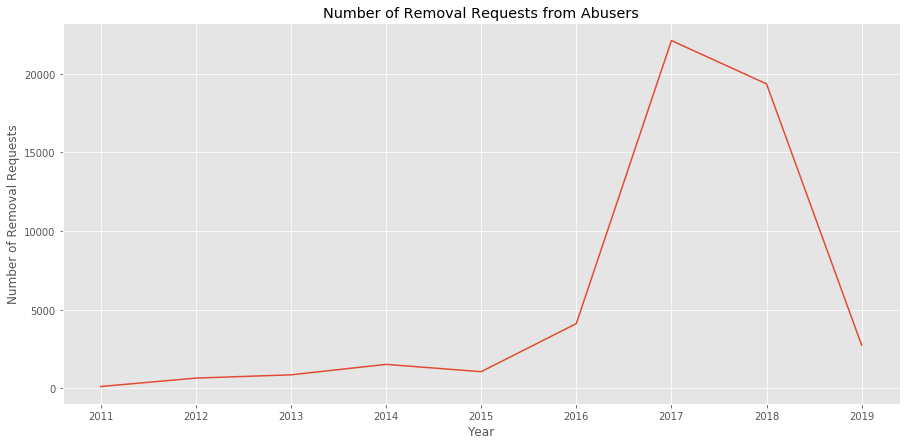

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
requests[requests['From Abuser']==True].groupby(['Year']).count()['Request ID'].plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Removal Requests')
ax.set_title('Number of Removal Requests from Abusers')

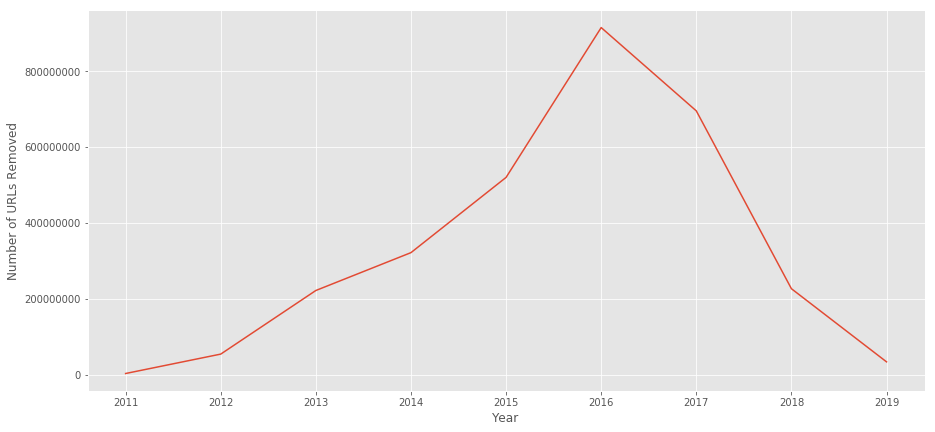

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
requests.groupby(['Year']).sum()['URLs removed'].plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of URLs Removed')
ax.get_yaxis().get_major_formatter().set_scientific(False)

In [12]:
#Number of Instances where Copyright owner name and Reporting organization name are the same
(requests[requests['Owner_ReportingOrg_match']==True]['Owner_ReportingOrg_match']).count()

945502

In [13]:
#Create column that counts number of unique Owner IDs for each Owner Name
requests['Number_of_owner_ids'] = requests.groupby('Copyright owner name')['Copyright owner ID'].transform('nunique')

In [14]:
#Number of Instances where Copyright owner name has more than one Copyright owner ID
(requests[requests['Number_of_owner_ids']>1]['Number_of_owner_ids']).count()

197913

In [15]:
#requests['More_than_one_ownerID'] = 
#np.where(requests.groupby('Copyright owner name')['Copyright owner ID'].transform('nunique') > 1, 'More than One Id', '')

In [16]:
#requests[~requests['Copyright ownerm name'].str.contains('[A-Za-z]', na=False)]

In [37]:
requests.head(4)

,Request ID,Date,Lumen URL,Copyright owner ID,Copyright owner name,Reporting organization ID,Reporting organization name,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review,From Abuser,Year,Copyright owner name_cleaned,Reporting organization name_cleaned,Owner_ReportingOrg_match,Number_of_owner_ids,Actionable_URLs,% Not in Search Index,% No Action
0,1,2012-05-23,http://www.chillingeffects.org/notice.cgi?sID=361307,22818,BPI (British Recorded Music Industry) Ltd,1847,BPI (British Recorded Music Industry) Ltd,1,0,0,0,False,2012,bpibritishrecordedmusicindustryltd,bpibritishrecordedmusicindustryltd,True,1.0,1,0.0,0.0
1,10,2011-12-07,http://www.chillingeffects.org/notice.cgi?sID=161547,25445,SEOmoz.ir,2951,seomoz.ir,6,0,4,0,False,2011,seomozir,seomozir,True,1.0,10,0.0,40.0
2,100,2012-04-28,http://www.chillingeffects.org/notice.cgi?sID=311540,22818,BPI (British Recorded Music Industry) Ltd,1847,BPI (British Recorded Music Industry) Ltd,7,0,0,0,False,2012,bpibritishrecordedmusicindustryltd,bpibritishrecordedmusicindustryltd,True,1.0,7,0.0,0.0
3,1000,2012-04-06,http://www.chillingeffects.org/notice.cgi?sID=266706,33428,"Malibu Media, LLC",6913,"Malibu Media, LLC",1,0,0,0,False,2012,malibumediallc,malibumediallc,True,1.0,1,0.0,0.0


In [28]:
requests['Actionable_URLs']= requests['URLs removed'] + requests["URLs that were not in Google's search index"] + requests["URLs for which we took no action"] \
+ requests["URLs pending review"]
requests['% Not in Search Index']= (requests["URLs that were not in Google's search index"] / requests['Actionable_URLs']) * 100
requests['% No Action']= (requests["URLs for which we took no action"] / requests['Actionable_URLs']) * 100

In [31]:
requests['% Not in Search Index'].mean() , \
requests['% No Action'].mean()

(12.047188368874062, 9.857193697410182)

In [63]:
gd=requests.groupby('Reporting organization name').agg({'Request ID': 'count', \
     "% Not in Search Index":'mean', "% No Action":'mean'}).sort_values(['Request ID'],ascending=False).head(20).reset_index().rename(columns={'Request ID': '# of Requests'}).round()

In [64]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(gd)

,Reporting organization name,# of Requests,% Not in Search Index,% No Action
0,AudioLock.NET,1874504,7.0,2.0
1,MUSO.com Anti-piracy,596919,33.0,7.0
2,BPI (British Recorded Music Industry) Ltd,449659,0.0,6.0
3,proMedia,433662,37.0,6.0
4,Digimarc,257716,6.0,18.0
5,Link-Busters.com,192102,10.0,16.0
6,Counterfeit.Technology,184702,11.0,1.0
7,RightBlaster,166058,7.0,7.0
8,rivendell,115086,27.0,5.0
9,Marketly llc,101173,2.0,2.0


In [58]:
requests.groupby('Copyright owner name').agg({'Request ID': 'count', \
     "% Not in Search Index":'mean', "% No Action":'mean'}).sort_values(['Request ID'],ascending=False).head(20).reset_index().rename(columns={'Request ID': '# of Requests'}).round()

,Copyright owner name,# of Requests,% Not in Search Index,% No Action
0,BPI LTD MEMBER COMPANIES,270724,0.0,4.0
1,BPI (British Recorded Music Industry) Ltd,141950,0.0,5.0
2,NUCLEAR BLAST RECORDS,101339,19.0,3.0
3,MX International Inc,72250,6.0,3.0
4,Universal Music GmbH,61032,30.0,5.0
5,IFPI,54930,14.0,6.0
6,APDIF do Brasil Member Companies,47871,45.0,8.0
7,Warner Music Group Germany Holding GmbH,47570,28.0,5.0
8,Beggars Group Digital Ltd,46601,18.0,12.0
9,Sony Music Entertainment Germany GmbH,46087,27.0,4.0


In [20]:
requests.groupby(['From Abuser'], as_index=True) \
.agg({'URLs removed':['sum','max','mean'],"URLs that were not in Google's search index":['sum', 'mean'],                           \
      'URLs for which we took no action':['sum', 'mean'], 'URLs pending review':['sum', 'mean'], 'Request ID':['count','max','mean']})

URLs removed                     \
                     sum    max        mean   
From Abuser                                   
False         2988587750  26927  406.572410   
True             3186548   9997   60.705403   

            URLs that were not in Google's search index             \
                                                    sum       mean   
From Abuser                                                          
False                                         661855710  90.039943   
True                                             374657   7.137411   

            URLs for which we took no action             URLs pending review  \
                                         sum        mean                 sum   
From Abuser                                                                    
False                              345491876   47.001285               45921   
True                                 8752803  166.745466               15627   

                      Request ID                         
                 mean      count      max          mean  
From Abuser                                              
False        0.006247    7350690  7410535  3.697044e+06  
True         0.297703      52492  7410210  5.180215e+06

In [18]:
requests.groupby(['Owner_ReportingOrg_match'], as_index=True) \
.agg({'URLs removed':['sum','max','mean'],"URLs that were not in Google's search index":['sum', 'mean'],                           \
      'URLs for which we took no action':['sum', 'mean'], 'URLs pending review':['sum', 'mean'], 'Request ID':['count','max','mean']})

URLs removed                     \
                                  sum    max        mean   
Owner_ReportingOrg_match                                   
False                      2847222486  26927  440.904858   
True                        144551812  19797  152.883666   

                         URLs that were not in Google's search index  \
                                                                 sum   
Owner_ReportingOrg_match                                               
False                                                      585383339   
True                                                        76847028   

                                    URLs for which we took no action  \
                               mean                              sum   
Owner_ReportingOrg_match                                               
False                     90.649171                        320668010   
True                      81.276431                         33576669   

                                    URLs pending review           Request ID  \
                               mean                 sum      mean      count   
Owner_ReportingOrg_match                                                       
False                     49.656844               25445  0.003940    6457680   
True                      35.512002               36103  0.038184     945502   

                                                 
                              max          mean  
Owner_ReportingOrg_match                         
False                     7410535  3.774382e+06  
True                      7410532  3.251179e+06

In [66]:
req_grouped= requests.groupby(['Reporting organization name'], as_index=True) \
.agg({'URLs removed':'sum', "URLs that were not in Google's search index":'sum',\
      'URLs for which we took no action':'sum', 'URLs pending review':'sum', 'Request ID':'count',  \
      'Copyright owner name': lambda x: "{}".format(x.value_counts())}).sort_values(['URLs removed'],ascending=False)

level0 = req_grouped.columns.get_level_values(0)
req_grouped.columns = level0
req_grouped.head(1000000)
requests__=req_grouped.reset_index().head(100000)

In [70]:
# Top 5 Reporting Org. and the number of Copyright Owners they've submitted URL removal requests for
requests__[['Reporting organization name','Copyright owner name']].head(5)

,Reporting organization name,Copyright owner name
0,BPI (British Recorded Music Industry) Ltd,"BPI LTD MEMBER COMPANIES 266424\nBPI (British Recorded Music Industry) Ltd 141921\nUNIVERSAL MUSIC LTD 5983\nSONY MUSIC ENTERTAINMENT 5962\nEMI 5297\nUniversal Music Ltd 4815\nWARNER MUSIC GROUP 4447\nSony Music Entertainment 2782\nUNIVERSAL MUSIC GROUP 2589\nWarner Music Group 1652\nXL RECORDINGS 639\nMINISTRY OF SOUND 604\nBPI (BRITISH RECORDED MUSIC INDUSTRY) LTD 360\nGLOBAL TALENT 315\nMTA 302\nFOOD 224\nDRAMATICO 119\nSOUR MASH 119\nNAIVE 113\nDOMINO RECORDINGS 100\nULTRA RECORDS 100\nMINISTRY OF SOUND RECORDINGS LIMITED 93\nTOOLROOM RECORDS 90\nSUPREME MUSIC 87\n3 BEAT RECORDS 82\nPEACEFROG 82\n3 BEAT_AATW 81\nCAPITOL 79\nREPRISE 79\nKITSUNE 77\n ... \nPias 1\nCR2 RECORDS 1\n333 RECORDS LTD 1\nNECESSARY MAYHEM 1\nANJUNABEATS 1\nSMALL GIANTS 1\nTHE WESTERN STAR RECORDING COMPANY 1\nFIERCE PANDA RECORDS 1\nMED SCHOOL MUSIC 1\nSPX GROUP 1\nFABRIC RECORDS 1\nVP Records 1\nSBMG 1\nCOPYRIGHT CONTROL 1\nSONY CLASSICAL 1\nGLASTONBURY FESTIVAL 1\nLONDON 1\nWARNER MUSIC GROUP1_2012-09-13_16361 1\nHEAVENLY 1\nPIAS ENTERTAINMENT 1\nDELTA 1\nTEXT 1\nFLUX DELUX DIGITAL 1\nDOUBLE SIX 1\nDRUM&BASSARENA 1\nUPRISING RECORDS 1\nADA 1\nMINSTRY OF SOUND 1\nSENA 1\nSOUL JAZZ RECORDS 1\nName: Copyright owner name, Length: 347, dtype: int64"
1,rivendell,"SCPP 14575\nMetropolitan 9242\nStudiocanal 6962\nsacem 6815\nCANAL+ 6261\ncitel video 6255\nToei Animation 5541\nVSTV (Vietnam Satellite Digital Television Company Limited) - K+ 3869\nViacom France 3705\nWild Side Video 3498\nPremier League EPL 3113\nLega Serie A 2708\nSEPM 2545\nMondadori 2127\nJour de fete 2114\nL'equipe 2022\nFrance Television Distribution 1957\nLe parisien 1922\nchrysalis 1856\nFox Pathe Europa 1843\nSPPF 1794\nCanalplus Sport 1631\nLe Figaro 1556\nLe point 1453\nGroupe La Depeche 1245\nWild Bunch Distribution 1190\nSophia Publications 1111\nSeven7 1050\nOCS 994\nAltice Media 928\n ... \nColumbia Pictures 3\nScreen Gems, Inc 3\nStudio 8 3\nFédération Française de Football 3\nViacces-orca 2\nSTX Financing, LLC. 2\nscpp 2\nSignature Entertainment Ltd 2\nKew Media Group 2\nBEUZ PRO 2\nFox Network Groups Inc 1\nOrion Releasing LLC dmc 1\nDisney Enterprises, Inc 1\nOpen Road Films 1\nProdiss 1\nCanal Plus 1\nelsa gougne 1\nSérie A TIM 1\nFOXER DMCA LTD 1\nSTX Financing, LLC 1\nWildside 1\nsppf 1\nDigiSay ..."
2,Remove Your Media LLC,"VIZ Media LLC 26031\nFUNimation Entertainment 8037\nMX International Inc 7513\nJapan Creative Contents Alliance LLC 7170\nITMPA 2802\nCJ Entertainment America 2348\nWell Go USA Entertainment 2276\nMadman Entertainment Pty Ltd 2236\nTVB USA Inc 1902\nAniplex of America Inc 1719\nNozomi Entertainment 1416\nSBS International Inc 1250\nRightstuf Inc 1065\nNIS America 1048\nCheng Cheng Films LLC 648\nChina Lion Entertainment 633\ntvN 603\n5 Points Pictures 261\nMichael Andrew Photography 253\nRemove Your Media LLC 233\nKBS America 227\nMBC America 197\nThunder Hill Pictures Inc 185\nGKIDS 143\nChrono Pop LLC 124\nOscar Crosby Films 75\nCWYWF Productions LLC 74\nViki Inc 72\nChalk It Up LLC 70\nVanishing Man LLC 67\n ... \nProdigee Media Sdn Bhd 13\nshueisha inc 10\nCS Fuji 8\nYG Entertainment 6\nFormosa TV 6\nNetflix 5\nAnime Rights Committee 5\nMX International 3\nViz Media LLC 3\nShueiSha Inc 2\nSM Culture & Contents Co Ltd 2\nFILM SIGNAL, INC 2\nGkids 2\nToei Animation 2\nNIPPON HOSO KYOKAI 1\nVIZ Media 1\nAniplex of America 1\nAniplex Inc. ( the ""Animation Company"") 1\nNBC Universal 1\nMichaelthemaven 1\nEllation, Inc. 1\nRightstuf Intl 1\nTelecinco Cinema 1\nMichaelthementor 1\nMadman Entertainment 1\nYouku Network Technology 1\nMx International 1\nJSTV 1\nELSobky For Film production 1\nBeşiktaş Kültür Merkezi A.Ş. 1\nName: Copyright owner name, Length: 72, dtype: int64"
3,Degban,"Froytal Services Ltd 14298\nMG Premium Ltd 11832\nCA Co., Ltd. 7344\nMG Content RK Limited 6417\nRK NetMedia Inc. 4102\nIntellectual Property Promotion Association 3611\nXFC In

In [23]:
# Copyright Owners with the max count/value for each URL field
requests.loc[:, 'Request ID'] = requests['Request ID'].astype(str)

d = lambda x: x.sum() if np.issubdtype(x.dtype, np.number) else x.count()
df1= requests[['Copyright owner name', 'Request ID', 'URLs removed',"URLs that were not in Google's search index", 'URLs for which we took no action', \
          'URLs pending review']].groupby("Copyright owner name").agg(d)

(df1.idxmax() + ': ' + df1.max().astype(str)).to_frame().T

,Request ID,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review
0,BPI LTD MEMBER COMPANIES: 270724,BPI LTD MEMBER COMPANIES: 423083199,VIZ Media LLC: 57332649,APDIF Mexico Member Companies: 84611425,"Multi Media, LLC: 11580"


In [24]:
# Reporting Org with the max count/value for each URL field

requests.loc[:, 'Request ID'] = requests['Request ID'].astype(str)

d = lambda x: x.sum() if np.issubdtype(x.dtype, np.number) else x.count()
df2= requests[['Reporting organization name', 'Request ID', 'URLs removed',"URLs that were not in Google's search index", 'URLs for which we took no action', \
          'URLs pending review']].groupby("Reporting organization name").agg(d)

(df2.idxmax() + ': ' + df2.max().astype(str)).to_frame().T

,Request ID,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review
0,AudioLock.NET: 1874504,BPI (British Recorded Music Industry) Ltd: 417970547,Aiplex Software Private Limited: 108702227,APDIF - Mexico: 85141356,"Multi Media, LLC: 11580"


# Domains

In [33]:
domains.head(5)

,Request ID,Domain,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review,From Abuser
0,1,zippyshare.com,1,0,0,0,False
1,10,pcalfa.com,6,0,4,0,False
2,100,4shared.com,7,0,0,0,False
3,1000,vk.com,1,0,0,0,False
4,10000,0sec.org,1,0,0,0,False


In [34]:
domains['Actionable_URLS'] = domains['URLs removed'] + domains["URLs that were not in Google's search index"]+domains['URLs for which we took no action']\
+domains['URLs pending review']
domains['% Not in Search Index']= (domains["URLs that were not in Google's search index"] / domains['Actionable_URLS']) * 100
domains['% No Action']= (domains["URLs for which we took no action"] / domains['Actionable_URLS']) * 100

In [71]:
domains.groupby(['Domain']).agg({'Request ID': 'count', '% Not in Search Index': 'mean', '% No Action':'mean'}).sort_values(['Request ID'],ascending=False)

,Request ID,% Not in Search Index,% No Action
Domain,,,
uploaded.net,568875,9.137125,6.492969
rapidgator.net,518497,15.905615,7.848139
zippyshare.com,466770,6.302879,7.765539
torrentdownloads.me,450375,11.776166,10.988493
limetorrents.cc,398960,13.475301,8.346272
chomikuj.pl,371511,10.147552,5.296851
turbobit.net,361594,37.507827,6.442786
4shared.com,355805,1.114247,10.294524
torrentz.eu,333745,0.566677,10.943709


In [36]:
#Overall % Average of Removal Requests that are NOT in the Search Index & No Action was taken
domains['% Not in Search Index'].mean() , \
domains['% No Action'].mean()

(8.880954178055704, 8.429422965495583)

In [ ]:
domains['% Not in Search Index'].rolling(5).mean()

In [5]:
#Domains with the max count/value for each URL field

domains.loc[:, 'Request ID'] = requests['Request ID'].astype(str)
d = lambda x: x.sum() if np.issubdtype(x.dtype, np.number) else x.count()
df3= domains.groupby("Domain").agg(d)

(df3.idxmax() + ': ' + df3.max().astype(str)).to_frame().T

,Request ID,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review,From Abuser
0,mp3vip.org: 39437,4shared.com: 62475306,unblocksites.co: 7397759,iplusfree.com: 6274698,webtoon365.com: 1172,uploaded.net: 568875


In [ ]:
df3

In [7]:
domains.groupby(['Domain'], as_index= True).agg({'Request ID': 'count', 'URLs removed':'sum', \
                                                 "URLs that were not in Google's search index":'sum',"URLs for which we took no action":'sum',\
                                                 'URLs pending review':'sum'}).sort_values(['Request ID','URLs removed'],ascending=False)

,Request ID,URLs removed,URLs that were not in Google's search index,URLs for which we took no action,URLs pending review
Domain,,,,,
mp3vip.org,39437,1689723,221,156197,0
myfreemp3.eu,37381,3428192,589,243887,0
4shared.com,34741,62475306,3074040,2579565,0
zippyshare.com,34495,11290162,966391,869867,2
limetorrents.com,31673,4382284,142531,451996,0
seedpeer.me,28251,3963075,129156,386580,0
torrenthound.com,28199,6746510,2368,707643,0
uploaded.net,27814,20099866,2364967,3031685,0
torrentreactor.net,26050,2476391,1746,330415,0


In [8]:
domains.groupby(['From Abuser']).agg({'Request ID': 'count', 'URLs removed':['sum', 'mean'], \
                                                 "URLs that were not in Google's search index":['sum','mean'],"URLs for which we took no action":['sum','mean'],\
                                                 'URLs pending review':['sum','mean']})

Request ID URLs removed             \
                 count          sum       mean   
From Abuser                                      
False          7391706   2988587750  12.375096   
True             11476      3186548   2.350688   

            URLs that were not in Google's search index            \
                                                    sum      mean   
From Abuser                                                         
False                                         661855710  2.740601   
True                                             374657  0.276381   

            URLs for which we took no action           URLs pending review  \
                                         sum      mean                 sum   
From Abuser                                                                  
False                              345491876  1.430607               45921   
True                                 8752803  6.456865               15627   

                       
                 mean  
From Abuser            
False        0.000190  
True         0.011528

In [9]:
#Total Number of URLs removed when the user was an Abuser
domains[domains['From Abuser']==True]['URLs removed'].sum()

3186548

In [10]:
domains[domains['From Abuser']==False]['URLs removed'].sum()

2988587750

# URLs No Action Taken

In [11]:
urls_no_action_taken.head(5)

,Request ID,Domain,URL,From Abuser
0,10000,null.vn,http://null.vn/vbb4/showthread.php?66090-FSN-Windows-7-Professional-SP1-Build-7601-Final-MULTi2-(x86-x64),False
1,10000,top4film.com,http://www.top4film.com/forum/archive/index.php/t-35697.html,False
2,1000019,yabeat.com,http://www.yabeat.com/download/BJhLDHWQpWk/EDX_-_Reckless_Ardor_Original_Mix.mp3.html,False
3,100002,vnmade.com,http://vnmade.com/?p=18280,False
4,100003,tugafun.com,http://tugafun.com/forum/viewtopic.php?f=47&amp;t=472225&amp;view=next,False


In [6]:
urls_no_action_taken.groupby(['Domain'], as_index=True) \
.agg({'Request ID':'count', 'URL':'count'}).sort_values(['Request ID','URL'],ascending=False)


,Request ID,URL
Domain,,
genteflowmp3.org,2698610,2698610
genteflowmp3.uno,2077114,2077114
suenamp3.com,2006554,2006554
genteflowmp3.com,1601635,1601635
iplusfree.com,1573494,1573494
genteflowmp3.me,1492785,1492785
taringamp3.com,1467853,1467853
genteflowmp3.eu,1426761,1426761
demp3.net,1380907,1380907
